# Setup - remote processing
Run this section if using remote processing (provided by Google) 

In [ ]:
# MOUNT GOOGLE DRIVE 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%matplotlib inline

# IMPORT LIBRARIES
import sys
import os
import numpy as np
import csv
import pandas as pd
import math
from scipy.optimize import curve_fit
import random
import glob
import subprocess
import matplotlib.pyplot as plt
from scipy.integrate import simps
from scipy.stats import norm


In [ ]:
PARENT_DIR = '/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/'


In [ ]:
# Ensure that Python looks in correct place for local modules 

DIR = PARENT_DIR

sys.path.append(DIR)

# IMPORT OWN FUNCTIONS
from utils.read_data_fns import * 
from utils.eval_fns import *


# Setup - local processing 


**Execute using local compute** 
(See https://research.google.com/colaboratory/local-runtimes.html)

Start notebook: 

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

In [ ]:
PARENT_DIR = 'C:/Users/reemb/content/drive/MyDrive/ReemSharedPhD/SharedCode/TOIS_paper_code/'

# Ensure that Python looks in correct place for local modules 
DIR = PARENT_DIR

sys.path.append(DIR)

# IMPORT OWN FUNCTIONS
from utils.read_data_fns import *
from utils.eval_fns import *

# Setup - shared

In [ ]:
# Setup evaluation directory
EVALDIR = os.path.join(DIR, 'tar_eval_out')    # Directory for evaluation output files

# Check whether dircetory exists and create it if not
if not os.path.exists(EVALDIR):
    os.makedirs(EVALDIR)

In [ ]:
# LOAD TOPIC RELEVANCE DATA
def load_rel_data(qrels): 
  qrel_fname =  os.path.join(DIR, qrels)
  with open(qrel_fname, 'r') as infile:
      qrels_data = infile.readlines()    
  query_rel_dic = make_rel_dic(qrels_data) # make dictionary of list of docids relevant to each queryid

  #print("Number of topics:", len(query_rel_dic))

  return qrel_fname, query_rel_dic

In [ ]:
# LOAD RUN DATA
def load_run_data(run): 
  run_fname = os.path.join(DIR, run)
  with open(run_fname, 'r') as infile: 
    run_data = infile.readlines()
  doc_rank_dic = make_rank_dic(run_data)  # make dictionary of ranked docids for each queryid
  rank_rel_dic = make_rank_rel_dic(query_rel_dic,doc_rank_dic) # make dic of list relevances of ranked docs for each queryid

  return doc_rank_dic, rank_rel_dic

# Visualise Results (CLEF)

In [ ]:
# Function to visualise results 
# Prints out recall (as line graph) and costs (as bar chart)
# Runs tar_eval and extracts metrics from output, then visualises

def create_graph(qrel_fname, out_fname, des_recall, title, fig_file_name): 

      # Location of script
      script = os.path.join(DIR, 'scripts/tar_eval.py')

      # Run tar_eval script
      #print("Calling {} {} {}".format(script, qrel_fname, out_fname))
      ret = subprocess.check_output(['python', script, qrel_fname, out_fname])
      ret = ret.decode(encoding='utf-8')

      # print(ret)

      # Parse eval script output
      teval_dict = {}   # Summary results (computed across all topics)
      for line in ret.split('\n'):
          # print(line) 
          if line != '' :
            tid, key, val = line.split()
            # print(f"tid: {tid}, key: {key}, val: {val}")
            if tid != 'ALL' :
                if key == 'topic_id':
                    teval_dict[tid] = {}
                teval_dict[tid][key] = val

      # Work through output and compute recall, cost and number of doc per topic
      recalls = {}
      costs = {}
      num_docs = {}
      num_rels = {}
      for tid in teval_dict:
          # Compute recall (rels_found / num_rel)
          recall = float(teval_dict[tid]['rels_found']) / float(teval_dict[tid]['num_rels'])
          recalls[tid] = recall

          # cost (num_shown / num_docs)
          cost = float(teval_dict[tid]['num_shown']) / float(teval_dict[tid]['num_docs'])
          costs[tid] = cost 

          num_docs[tid] = float(teval_dict[tid]['num_docs'])
          num_rels[tid] = float(teval_dict[tid]['num_rels'])

      # Create list of topics sorted by number of documents (ascending)
      # (Potentially also sort by number of relevant documents)
      
      sorted_tids = sorted(num_docs, key=num_docs.get, reverse=False)
      ## Optionally sort by number of relevant documents 
      ## sorted_tids = sorted(num_rels, key=num_rels.get, reverse=False)
   
      recall_list = [recalls[tid] for tid in sorted_tids]
      cost_list = [costs[tid] for tid in sorted_tids]        

      # Produce graphs 
      num_docs_list = [num_docs[tid] for tid in sorted_tids]   
      ind = np.arange(len(recall_list)) 
      ind = ind + 1

      # Plot recalls (as line chart)
      plt.plot(ind, recall_list, color='k', label='recall') 
      # Draw horizontal line showing target recall
      plt.axhline(y=des_recall, xmin=0, xmax=1, color='k', linestyle='dotted', label='target-recall') 

      # Plot cost (as greyscale bars) 
      plt.bar(ind, cost_list, color='0.6', label = 'cost')

      # Set axis labels 
      plt.ylabel('Recall / Cost')
 
      # Label x-axis
      x1 = range (5, 31, 5)
      x_labels = [int(num_docs[sorted_tids[i - 1]]) for i in x1]
      ## Use if sorting by number of relevant docs
      ## x_labels = [num_rels[sorted_tids[i - 1]] for i in x1]
      plt.xticks(x1, x_labels)

      # Set area of entire graph to look neat 
      plt.xlim(0.5,len(recalls)+0.5)
      plt.ylim(0, 1.05)
      # plt.title(title)
      # plt.grid(True)

      # add legend
      #plt.legend()


      plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

      plt.tight_layout() #save full figure without cropped legened
      
      plt.savefig(os.path.join(figs_path,fig_file_name))
      plt.show()
 
      return 1

## per topic with legend

Oracle (Recall  = 1.0)


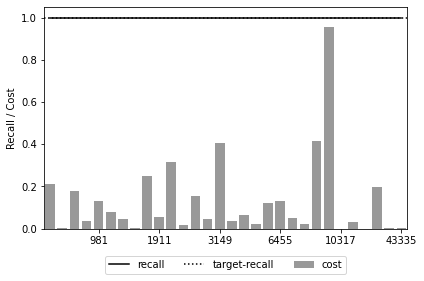

IP-P (Recall  = 1.0)


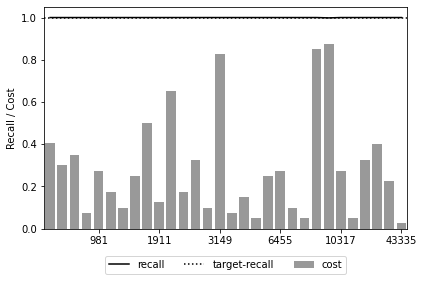

IP-E (Recall  = 1.0)


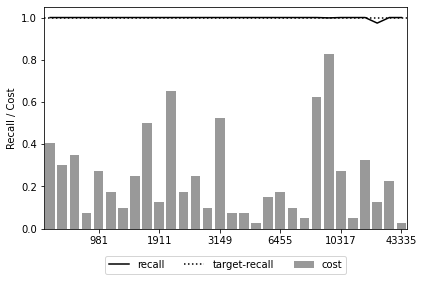

IP-A (Recall  = 1.0)


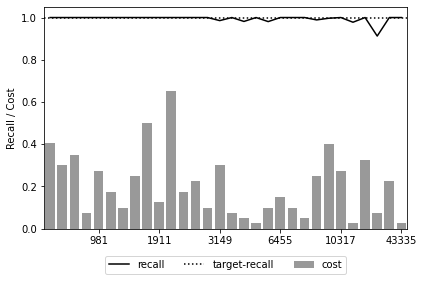

IP-H (Recall  = 1.0)


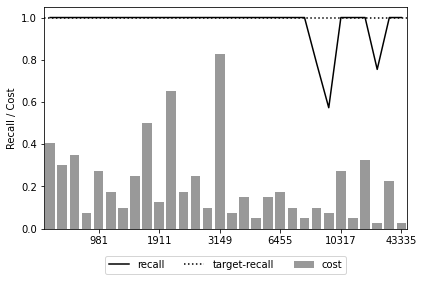

Oracle (Recall  = 0.9)


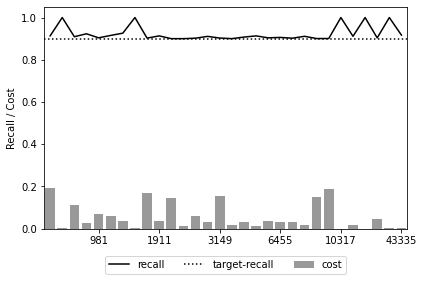

IP-P (Recall  = 0.9)


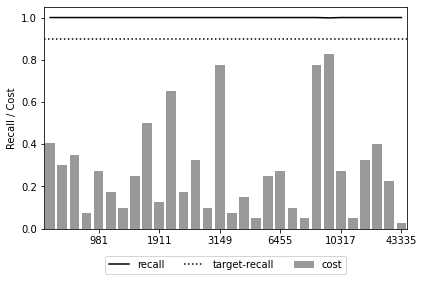

IP-E (Recall  = 0.9)


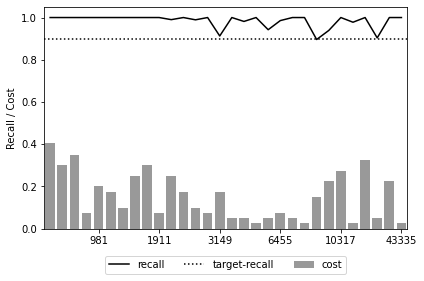

IP-A (Recall  = 0.9)


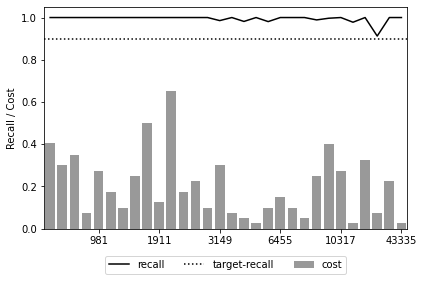

IP-H (Recall  = 0.9)


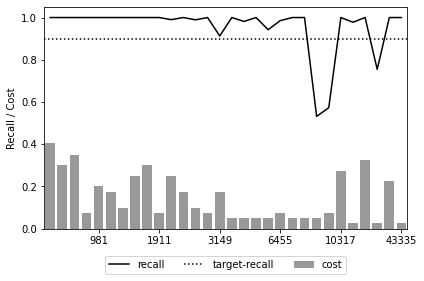

Oracle (Recall  = 0.8)


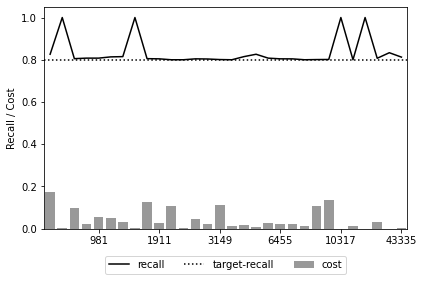

IP-P (Recall  = 0.8)


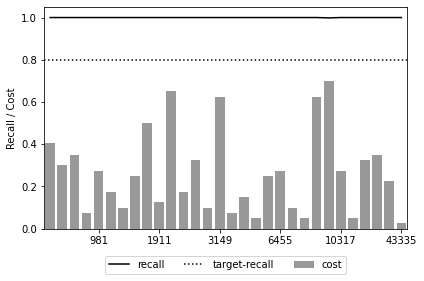

IP-E (Recall  = 0.8)


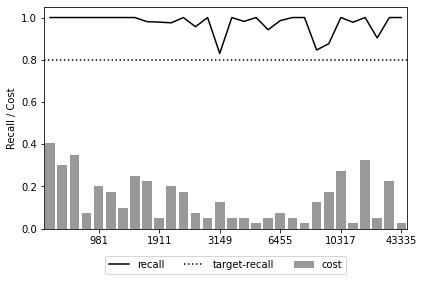

IP-A (Recall  = 0.8)


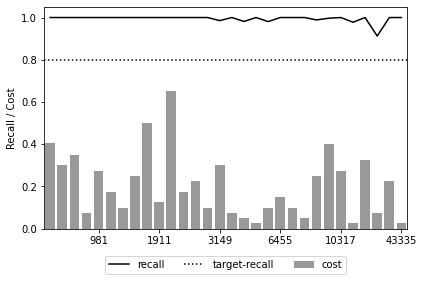

IP-H (Recall  = 0.8)


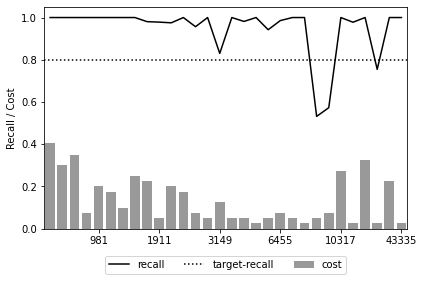

In [ ]:
figs_path = os.path.join(DIR,'results','figs','per_topic_figs')

# Check whether dircetory exists and create it if not
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

dataset = 'CLEF2017'
qrels = "data/qrels/CLEF2017_qrels.txt" # use the same qrel list as their rankings
run = "data/rankings/clef2017_autotar_ranking.txt"


# Visualise outputs for CLEF 2017 data set 

qrel_fname, query_rel_dic = load_rel_data(qrels)
#print("Number of topics:", len(query_rel_dic))


doc_rank_dic, rank_rel_dic = load_run_data(run)

des_prob = 0.95

des_recalls = [1.0, 0.9, 0.8]


for des_recall in des_recalls:
  out_fname = dataset + "_Oracle_"+str(des_recall)+".txt"
  out_fname = os.path.join(EVALDIR, out_fname)


  legend = "Oracle (Recall  = "+str(des_recall)+")"
  print(legend)
  fig_file_name = dataset + "_oracle_"+str(des_recall)+".png"
  create_graph(qrel_fname, out_fname, des_recall, legend, fig_file_name)

  #for process in ["IP", "CX"]:
  for process in ["IP"]: 
    for model in ["P", "E", "A", "H"]:
      out_fname = str(process)+"_"+str(model)+"_"+str(des_recall)+"_"+str(des_prob)+".txt"
      out_fname = dataset+"_"+str(process)+"_"+str(model)+"_"+str(des_recall)+"_"+str(des_prob)+".txt"
      out_fname = os.path.join(EVALDIR, out_fname)
      

      legend = str(process)+"-"+str(model)+" (Recall  = "+str(des_recall)+")"
      print(legend) 
      fig_file_name = dataset+"_"+str(process)+"_"+str(model)+"_"+str(des_recall)+".png"
      create_graph(qrel_fname, out_fname, des_recall, legend , fig_file_name)




IP-P (Recall  = 1.0)


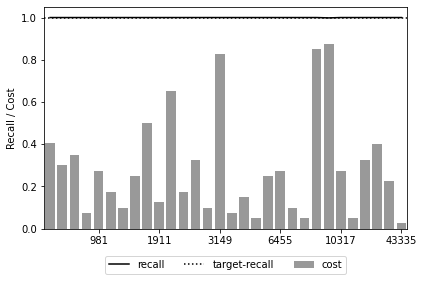

IP-E (Recall  = 1.0)


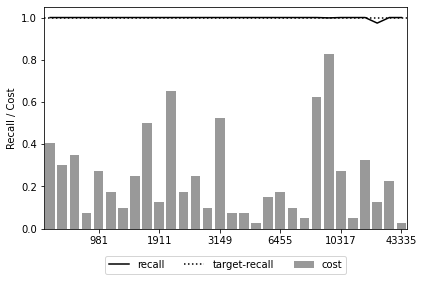

IP-A (Recall  = 1.0)


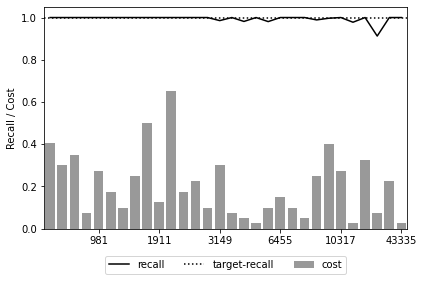

IP-H (Recall  = 1.0)


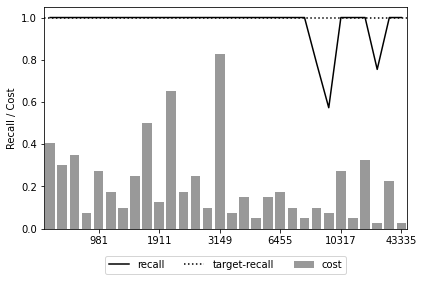

CX-P (Recall  = 1.0)


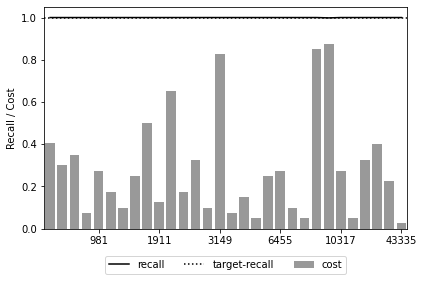

CX-E (Recall  = 1.0)


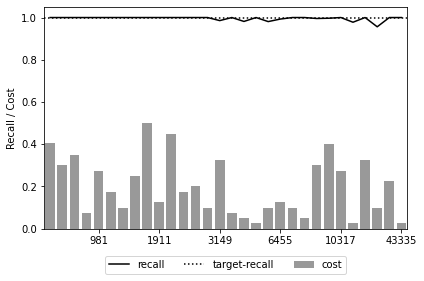

CX-A (Recall  = 1.0)


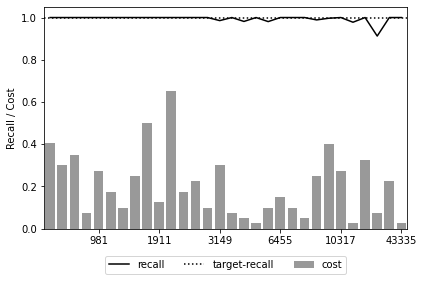

CX-H (Recall  = 1.0)


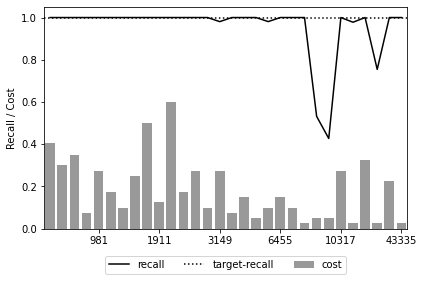

IP-P (Recall  = 0.9)


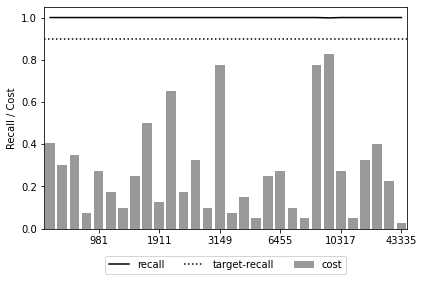

IP-E (Recall  = 0.9)


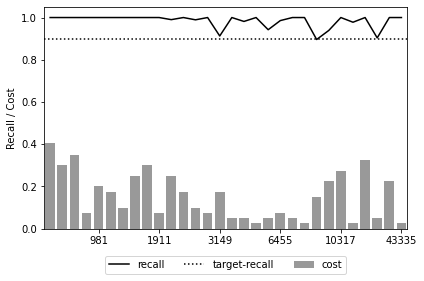

IP-A (Recall  = 0.9)


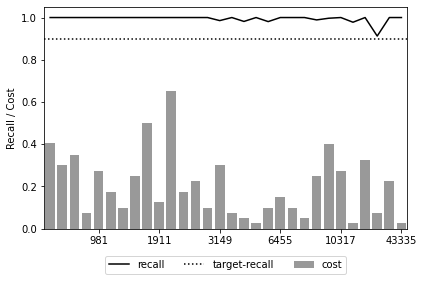

IP-H (Recall  = 0.9)


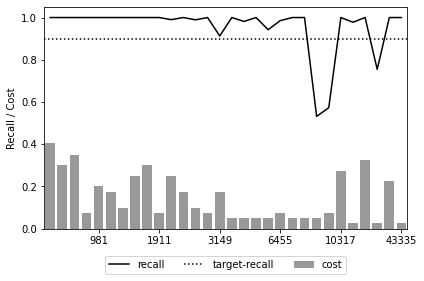

CX-P (Recall  = 0.9)


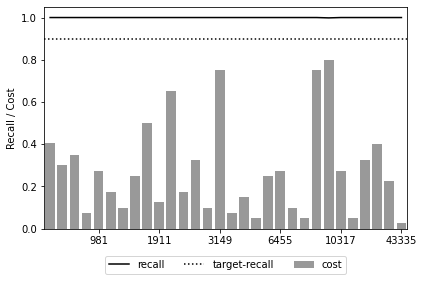

CX-E (Recall  = 0.9)


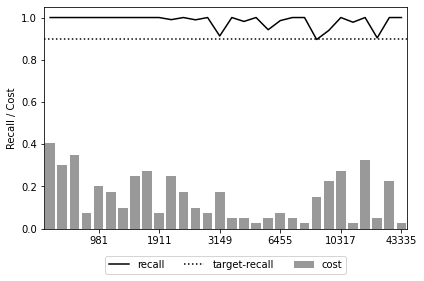

CX-A (Recall  = 0.9)


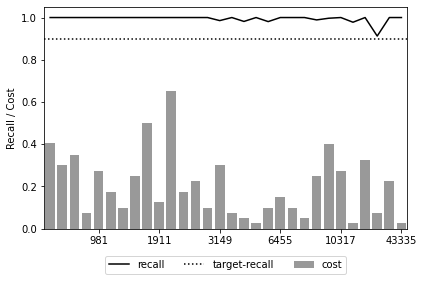

CX-H (Recall  = 0.9)


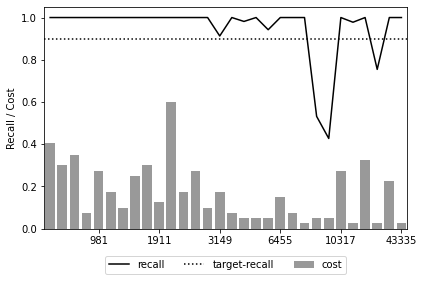

IP-P (Recall  = 0.8)


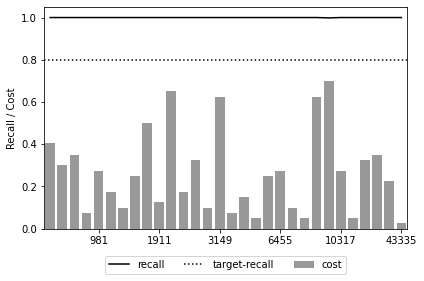

IP-E (Recall  = 0.8)


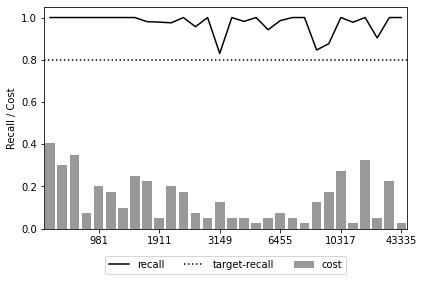

IP-A (Recall  = 0.8)


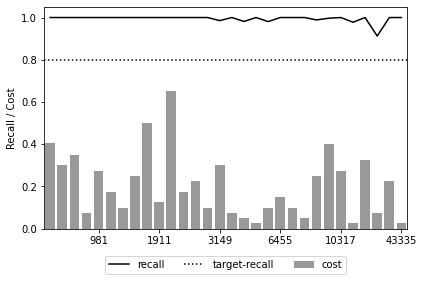

IP-H (Recall  = 0.8)


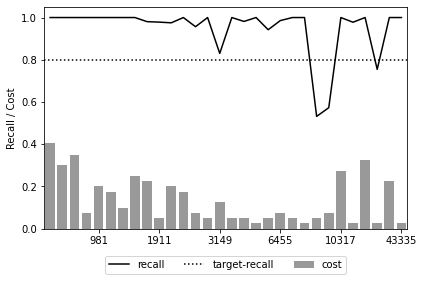

CX-P (Recall  = 0.8)


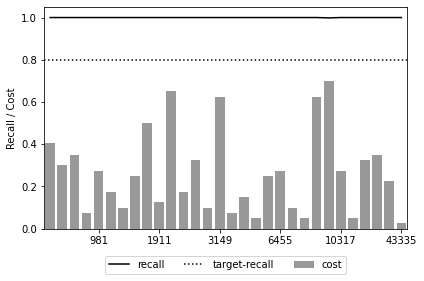

CX-E (Recall  = 0.8)


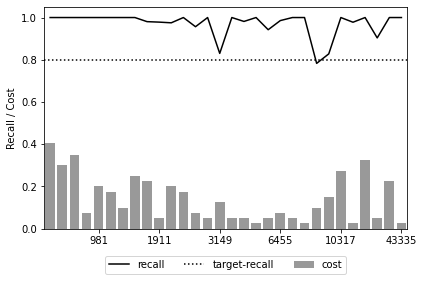

CX-A (Recall  = 0.8)


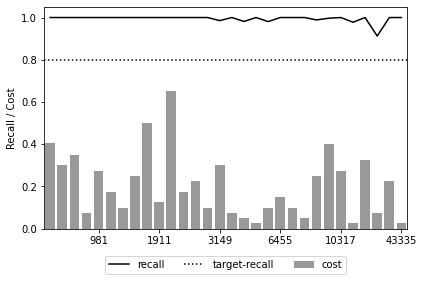

CX-H (Recall  = 0.8)


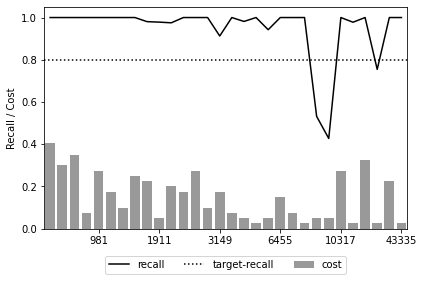

In [ ]:
#all CX results
EVALDIR = os.path.join(DIR, 'TTest', 'tar_eval_out')    # Directory for evaluation output files

figs_path = os.path.join(DIR,'results','figs','per_topic_figs')

# Check whether dircetory exists and create it if not
if not os.path.exists(figs_path):
    os.makedirs(figs_path)

dataset = 'CLEF2017'
qrels = "data/qrels/CLEF2017_qrels.txt" # use the same qrel list as their rankings
run = "data/rankings/clef2017_autotar_ranking.txt"


# Visualise outputs for CLEF 2017 data set 

qrel_fname, query_rel_dic = load_rel_data(qrels)
#print("Number of topics:", len(query_rel_dic))


doc_rank_dic, rank_rel_dic = load_run_data(run)

des_prob = 0.95

des_recalls = [1.0, 0.9, 0.8]


for des_recall in des_recalls:
  #out_fname = dataset + "_Oracle_"+str(des_recall)+".txt"
  #out_fname = os.path.join(EVALDIR, out_fname)


  #legend = "Oracle (Recall  = "+str(des_recall)+")"
  #print(legend)
  #fig_file_name = dataset + "_oracle_"+str(des_recall)+".png"
  #create_graph(qrel_fname, out_fname, des_recall, legend, fig_file_name)

  for process in ["IP", "CX"]:
  #for process in ["IP"]: 
    for model in ["P", "E", "A", "H"]:
      out_fname = str(process)+"_"+str(model)+"_"+str(des_recall)+"_"+str(des_prob)+".txt"
      out_fname = dataset+"_"+str(process)+"_"+str(model)+"_"+str(des_recall)+"_"+str(des_prob)+".txt"
      out_fname = os.path.join(EVALDIR, out_fname)
      

      legend = str(process)+"-"+str(model)+" (Recall  = "+str(des_recall)+")"
      print(legend) 
      fig_file_name = dataset+"_"+str(process)+"_"+str(model)+"_"+str(des_recall)+".png"
      create_graph(qrel_fname, out_fname, des_recall, legend , fig_file_name)


